In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict

from matplotlib import pyplot as plt

from pyballmapper import BallMapper

# to generate data
from sklearn import datasets

# for finding epsilon net
from tqdm.notebook import tqdm

# for adaptive mapper
from math import log2, log, pi

import itertools
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn_extra.cluster import KMedoids

In [2]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# Create data and initial ball mapper

In [3]:
X, l = datasets.make_circles(n_samples=200,
                                 shuffle=True,
                                 noise=0.01,
                                 random_state=0, # 42 normally, 0 otherwise
                                 factor=0.4)

In [ ]:
X, l = datasets.make_circles(n_samples=200,
                                 shuffle=False,
                                 noise=0.01,
                                 random_state=0, # 42 normally, 0 otherwise
                                 factor=0.4)

In [ ]:
# n=200
# m=400
# X=np.zeros((n+m,2))
# for i in range(n):
#     angle = np.pi * np.random.uniform(0, 2)
#     X[i,0] = np.cos(angle)
#     X[i,1] = np.sin(angle)
# for i in range(m):
#     angle = np.pi * np.random.uniform(0, 2)
#     X[n+i,0] = np.cos(angle)*2
#     X[n+i,1] = np.sin(angle)*2

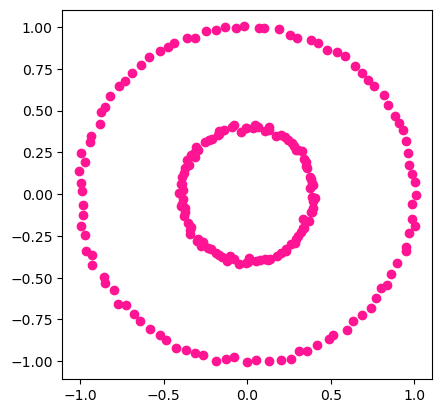

In [4]:
plt.scatter(X[:,0], X[:,1], color = 'deeppink')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# plt.show()
# plt.savefig('point_cloud.svg') # this doesn't work with new matplotlib

pyBallMapper indexes things differently than my epsilon net. Can't put the output of pyBallMapper into adaptive covers

In [5]:
# radius 0.31
bm = BallMapper(X, # the pointcloud, as a numpy array
                eps = 0.31)            # the radius of the balls

In [6]:
# bm = BallMapper(points = X, # the pointcloud, as a numpy array
#                 epsilon = 1)            # the radius of the balls

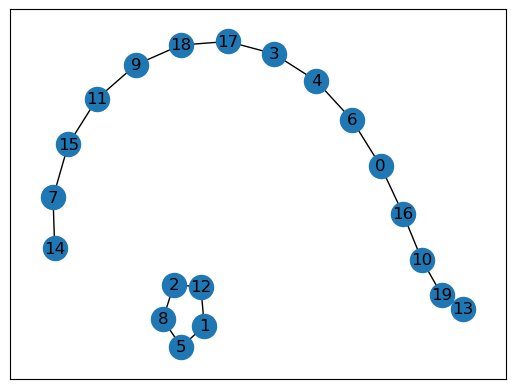

In [7]:
# Ball mapper doesn't work well regardless of epsilon
nx.draw_networkx(bm.Graph, 
                 pos=nx.spring_layout(bm.Graph, seed=24))

# Function to get epsilon net

In [28]:
# input points and epsilon, output epsilon net (soft covering)
# subset is if you only want to find the net on a subset of points. If you want all points, set
# subset = range(len(points))
# open cover landmarks are medoid of each cover element
def get_epsilon_net(points, subset, epsilon, distance=None):
    
    # if distance is not specified, use Euclidean distance
    if not distance:
        distance = lambda x, y : np.linalg.norm(x - y)        
            
    landmarks = []
    
    # get epsilon net
    for idx_p in subset:

        # current point
        p = points[idx_p]
        
        is_covered = False

        for idx_v in landmarks:
            if distance(p, points[idx_v]) <= epsilon:
                is_covered = True
                break
                
        if not is_covered:
            landmarks.append(idx_p)
    
    # this is a soft clustering
    points_covered_by_landmarks = dict()
    for idx_v in landmarks:
        points_covered_by_landmarks[idx_v] = []
        for idx_p in subset:
            if distance(points[idx_p], points[idx_v]) <= epsilon:
                points_covered_by_landmarks[idx_v].append(idx_p)
                
    medoids = []
    for i in points_covered_by_landmarks.keys():
        kmedoids = KMedoids(n_clusters=1, random_state=0).fit(points[points_covered_by_landmarks[i]])
        # need this line to actually get the number
        new_key = np.where(np.all(points==kmedoids.cluster_centers_,axis=1))[0][0]
        medoids.append(new_key)
    
    pcbl_medoids = dict()
    
    for i,j in enumerate(points_covered_by_landmarks.keys()):
        pcbl_medoids[medoids[i]] = points_covered_by_landmarks[j]
    
    # all soft clusterings need to be sorted in order, or else bad results (not necessarily errors) will happen
    # eg test_balls will want to split things that shouldn't be split
    pcbl_medoids = dict(sorted(pcbl_medoids.items()))
                
    return pcbl_medoids

# Function to find initial hard clustering

In [121]:
def hard_clustering(points, subset, soft_clustering, distance=None):
    
    # if distance is not specified, use Euclidean distance
    if not distance:
        distance = lambda x, y : np.linalg.norm(x - y)
        
    landmarks = list(soft_clustering.keys())
        
    # invert soft_clustering so that it's {point:[landmarks covering point]}    
    new_dic = {}
    for k,v in soft_clustering.items():
        for x in v:
            new_dic.setdefault(x,[]).append(k)
    
    # initialize clustering vector
    clustering = [0]*len(points)
    
    for i in new_dic:
        # if point is in only one cluster, then done
        if len(new_dic[i]) == 1:
            clustering[i] = new_dic[i][0]
        # if point is in multiple clusters, find closest center
        else:
            clustering[i] = new_dic[i][cdist([points[i]], points[new_dic[i]]).argmin()]
    
    return landmarks, clustering

In [10]:
# distance_function = lambda x, y : np.linalg.norm(x - y)

In [73]:
test_soft_cluster = get_epsilon_net(X, range(len(X)), 0.31)

0


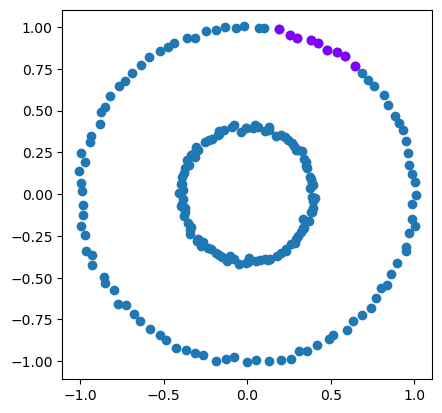

2


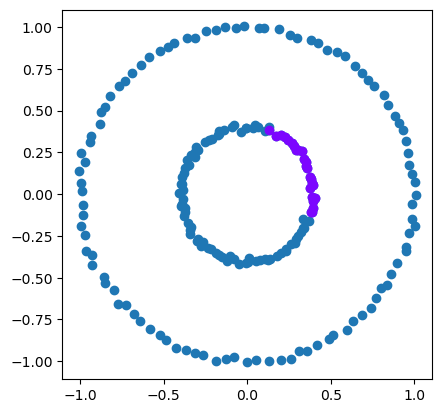

3


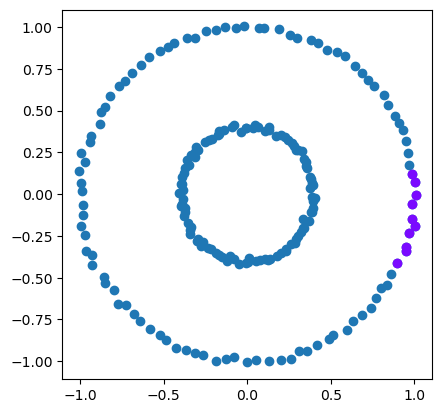

6


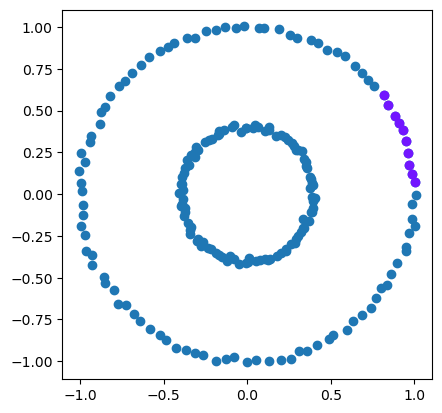

7


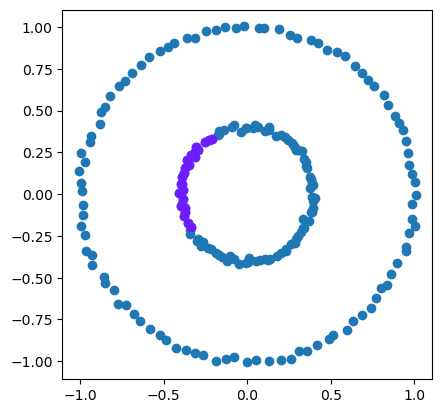

8


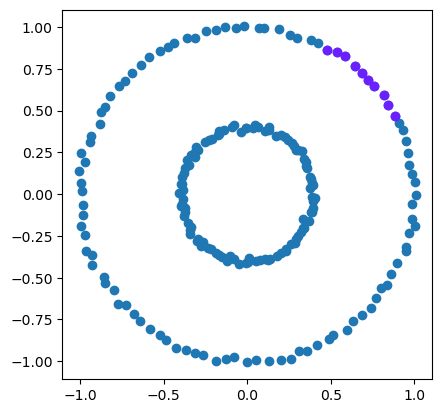

10


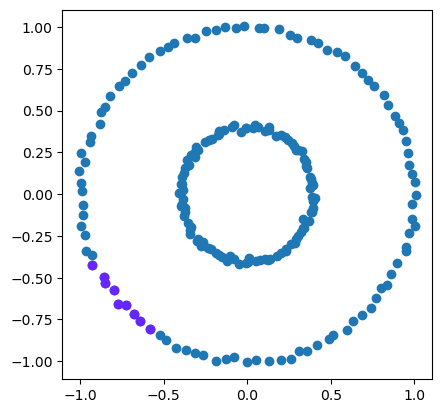

14


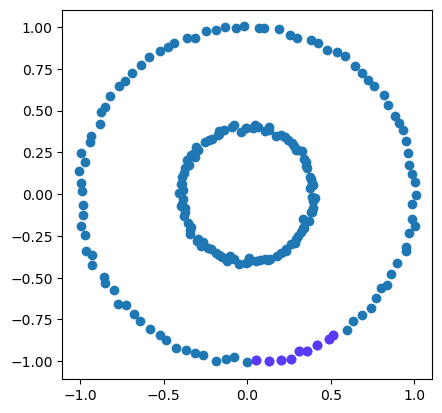

16


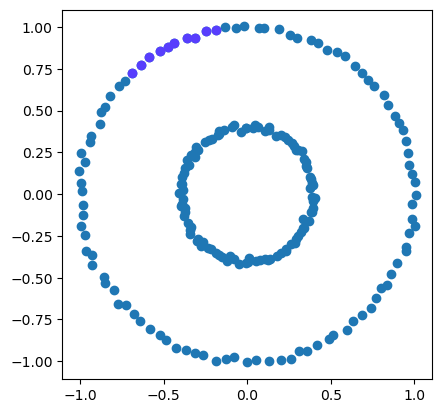

22


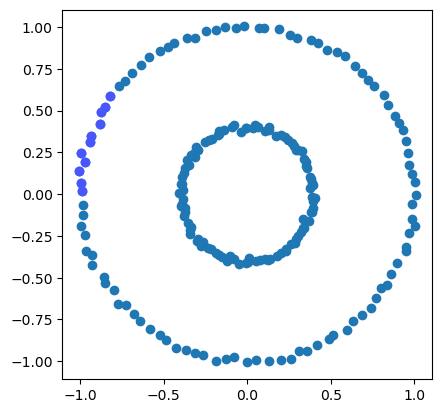

27


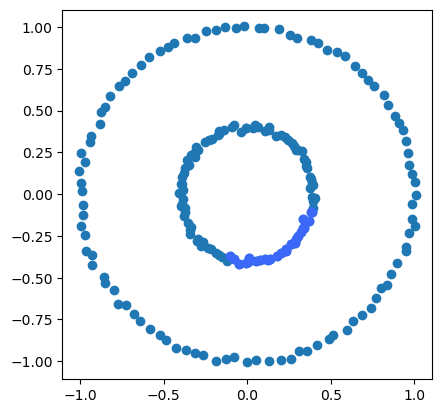

41


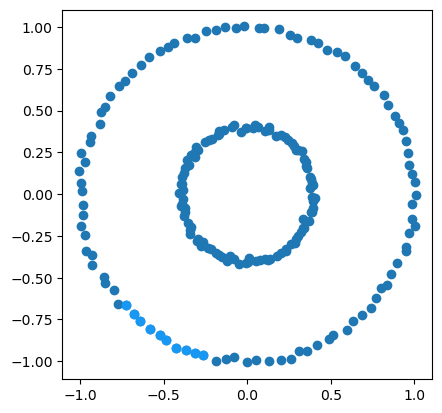

42


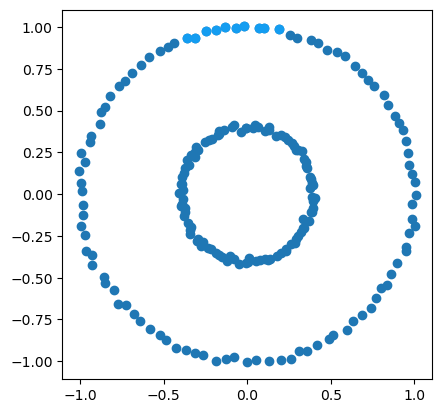

59


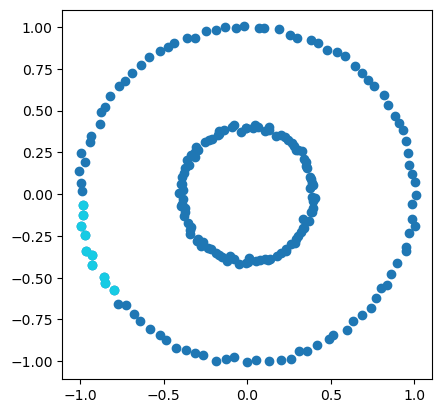

65


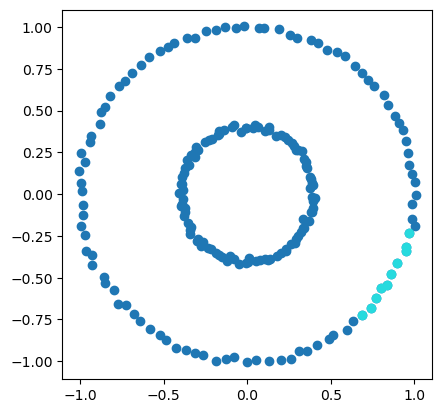

69


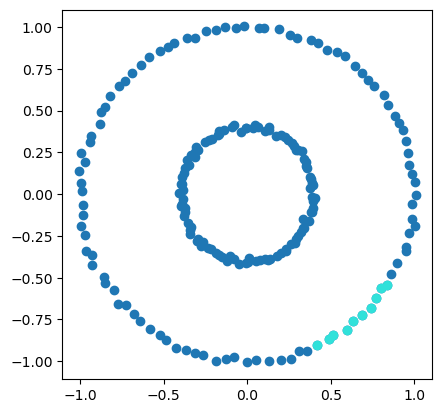

93


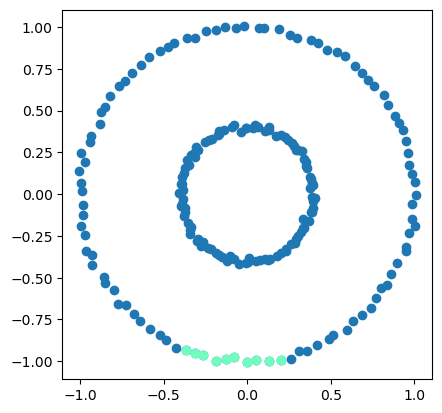

97


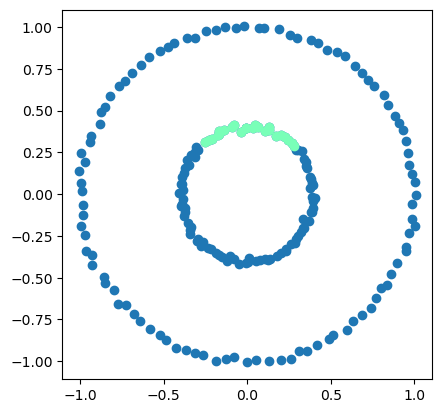

135


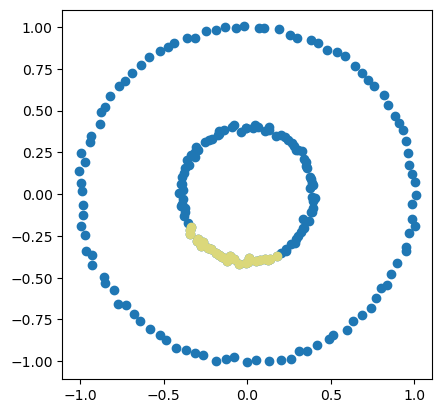

153


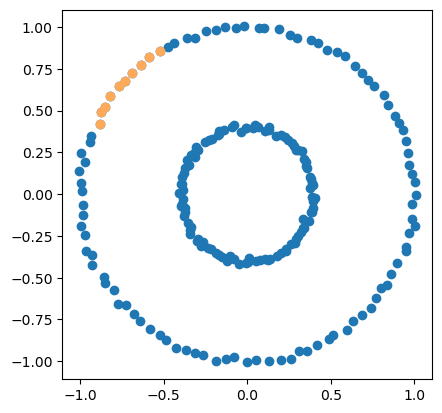

In [13]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(X)))

for i in test_soft_cluster.keys():
    print(i)
    plt.scatter(X[:,0], X[:,1], label = "original")
    test_subset = X[test_soft_cluster[i]]
    plt.scatter(test_subset[:,0], test_subset[:,1], label = "original", color = colors[i])
# plt.scatter(X[173,0], X[173,1], label = "original", color = "red")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

In [14]:
color_list = ["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#ffff99","#b15928"]

In [15]:
color_list2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

In [16]:
tc_keys = {k:v for k, v in zip(test_clustering[0], color_list2+color_list2+color_list2)}

In [17]:
test_clustering_colors = [tc_keys[i] for i in test_clustering[1]]

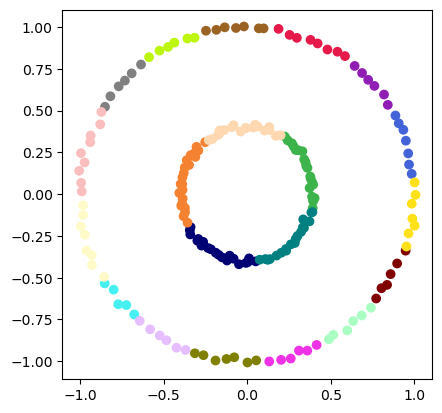

In [18]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.scatter(X[:,0], X[:,1], label = "original", color = test_clustering_colors)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

# Function to compute BIC

In [19]:
def bic_centroid(X, c, assignments, BIC=True):
    '''
    Method for computing the BIC or AIC. 
    @param: X - the point cloud to evaluate over. n points x d dimensions
    @param: c - cluster centroids. c centroids x d dimensions
    @params: assigments - Cluster assignments for n points.
    @params: BIC - Defaults to True. Setting False computes the AIC.
    '''
    k = len(c)
    d = X.shape[1]
    R = X.shape[0]
    var = 0
    log_term = 0


    assignments = np.asarray(assignments, dtype=int)
    for i in range(k):
        cluster_members = X[assignments == assignments[i]]
        log_term += cluster_members.shape[0] * \
            (log(cluster_members.shape[0]) - log(R))
        sum_squares = np.linalg.norm(cluster_members - c[i], axis=1) ** 2
        var = var + sum_squares.sum()
    var = var / (R - k)
    t2 = -1 * (R*d / 2) * log(2*pi*var)
    t3 = -1 * (1 / 2) * (R-k)
    llh = log_term + t2 + t3
    if BIC:
        return llh - ((k * (d+1))/2) * log(R)  # bic
    else:
        return 2 * llh - ((k * (d + 1))) * 2  # aic

In [20]:
bic_centroid(X, X[test_clustering[0]], test_clustering[1])

-1388.3751611489488

#### New BIC

In [ ]:
# # get matrix whose rows are points and columns are clusters
# # values are membership weights, rows should sum to 1
# # number of columns will change for each iteration of splitting/merging

# def get_fuzzy_weights(points, soft_clustering):
#     weights_dict = Counter(v for sublist in soft_clustering.values() for v in sublist)
#     fuzzy_weights_matrix = np.zeros((len(points), len(soft_clustering)))
    
#     for i in range(len(points)):
#         for j, k in enumerate(soft_clustering):
#             if i in soft_clustering[k]:
#                 fuzzy_weights_matrix[i,j] = 1/weights_dict[j]
                
#     return fuzzy_weights_matrix

In [ ]:
# get_fuzzy_weights(X, test_soft_cluster)

In [ ]:
# def fuzzy_bic:

# Function to split a ball

In [ ]:
# centers of clusters will always be pre-existing points, so use point labels as cluster labels

Check if BIC improves for a split

In [30]:
# test input balls to see if splitting at radius delta would improve bic
def test_balls(points, soft_clustering, to_test, radius):
    
    # find hard clustering of entire set with input soft clustering
    old_hard_cluster = hard_clustering(points, range(len(points)), soft_clustering)[1]
    
    # compute bic for entire data set and old soft clustering
    bic =  bic_centroid(points, points[list(soft_clustering.keys())], old_hard_cluster, BIC=True)
    
    # if we don't split anything, to_split is just empty list
    to_split = []
    
    test_dictionary = soft_clustering.copy()

    # for each ball of the currently tested radius in soft clustering
    for i in to_test:
        
        # get soft cover of just the ball in question
        # note that sometimes this doesn't split the ball, if all the points can be covered by a smaller radius
        new_epsilon_net = get_epsilon_net(points, soft_clustering[i], radius)
        
        
        # delete old ball center because we do not want to include it in the bic test
        del test_dictionary[i]
        
        # if one ball is contained in another, take the bigger ball
        is_covered_dict = test_dictionary.copy()
        is_covered = set(flatten(is_covered_dict.values()))
        balls_to_delete = []
        for j in new_epsilon_net.keys():
            if set(new_epsilon_net[j]).issubset(is_covered):
                balls_to_delete.append(j)
        for k in balls_to_delete:
            del new_epsilon_net[k]
        
        # merge soft cluster of ball in question with soft cluster of whole set
        # if there are two balls with same center, take their union
        z = {key:new_epsilon_net.get(key,[])+test_dictionary.get(key,[]) for key in set(list(new_epsilon_net.keys())+list(test_dictionary.keys()))}
        z = dict(sorted(z.items()))
        
        test_dictionary = z
                
        # get hard cluster of whole set
        
        new_hard_cluster = hard_clustering(points, range(len(points)), z)[1]
        
        # compute new global bic for splitting the ball
        new_bic = bic_centroid(points, points[list(z.keys())], new_hard_cluster, BIC=True)

        # if new bic is better, split the ball, and now the new bic is the standard to test against
        if new_bic > bic:
            # accept split
            to_split.append(i)
            bic = new_bic
        
    return to_split

In [22]:
bic_centroid(X, X[0], list(range(len(X))))

347.5092281292904

# Function to merge balls

1) Compute distance matrix from all centers to each other

2) For each row in the distance matrix, find two (or three, etc) smallest values

3) Test if the balls representing these values should be merged

4) Remove the transpose of the tested values from the matrix (this is not just to make searching the matrix easier, it's because they are likely to be merged (so it would make no sense to test) or already tested)
    
5) Repeat for all rows in the matrix

In [ ]:
# bic should be bigger

In [31]:
# GLOBAL
# non-euclidean distance function not supported yet
# n is number of closest balls to test

# the way this works is that it tests each ball to see if it should merge. If a ball has already been merged this
# round, then that ball is skipped. 
def merge_balls(points, soft_clustering, n, distance=None):
    
    # if distance is not specified, use Euclidean distance
    if not distance:
        distance = 'euclidean'   
    
#     # get distances between centers
#     dm = squareform(pdist(points[list(soft_clustering.keys())], distance))

    # distance between centers = distance between closest points of balls with those centers
    dm = np.zeros((len(soft_clustering), len(soft_clustering)))
    
    dict_keys = list(soft_clustering.keys())
    
    for i,j in itertools.product(range(len(dict_keys)), range(len(dict_keys))):
        dm[i,j] = np.min(cdist(points[soft_clustering[dict_keys[i]]], points[soft_clustering[dict_keys[j]]]))

    # get initial bic
    initial_hard_cluster = hard_clustering(points, range(len(points)), soft_clustering)
    new_bic = bic_centroid(points, points[initial_hard_cluster[0]], initial_hard_cluster[1], BIC=True)
    
    temp_clustering = soft_clustering.copy()
    
    # if two balls have been merged, exclude them from future merging
    
    merged_keys = []
    
    # first value in minimum is the distance between center and itself value. The next 2 are the two closest centers
    for i in range(len(dm)):
        # first, find the n+1 smallest values in order. Pick the n larger ones to leave out the smallest
        # note these give the index of the ball that is the minimum, not the actual key
        minimums = list(np.argpartition(dm[i], n+1)[0:n+1])

        # remove the center of the ball in question, don't need to test against that
        # if there are a ton of overlapped balls, ball in question may not be in minimums if n is small
        if i in minimums:
            minimums.remove(i)
        
        for j in minimums:
            if list(soft_clustering.keys())[j] in merged_keys:
                minimums.remove(j)
        
        # if all minimums have already been merged into other balls, skip this ball in question
        if len(minimums) == 0:
            continue
        
        # get key of ball in question
        key = list(soft_clustering.keys())[i]
        
        # if this ball in question has already been merged into another ball, skip this ball in question
        if key in merged_keys:
            continue

        key_to_merge = []
        final_new_key = []
        
        # test each of the unprocessed closest balls to chosen ball
        for j in range(len(minimums)):
            # turn index into key
            key1 = list(soft_clustering.keys())[minimums[j]]
            
            if key1 in merged_keys:
                continue

            # make copy of dictionary so things don't get messed up
            testing_dictionary = soft_clustering.copy()
            
            # find new center of merged balls
            # this returns some generating type function thing
            kmedoids = KMedoids(n_clusters=1, random_state=0).fit(points[list(set(soft_clustering[key]+soft_clustering[key1]))])
            # need this line to actually get the number
            new_key = np.where(np.all(points==kmedoids.cluster_centers_,axis=1))[0][0]

            # need to delete here in case key or key1 is equal to new key            
            del testing_dictionary[key]
            del testing_dictionary[key1]
            
            # merge the two values in the dictionary
            testing_dictionary[new_key] = list(set(soft_clustering[key]+soft_clustering[key1]))
            
            testing_dictionary = dict(sorted(testing_dictionary.items()))
            
            # global hard cluster with new dictionary with merge
            testing_hard_cluster = hard_clustering(points, range(len(X)), testing_dictionary)

            # global bic
            temp_bic = bic_centroid(points, points[testing_hard_cluster[0]], testing_hard_cluster[1], BIC = True) 
            
            if temp_bic > new_bic:
                # append key in question to show that merging this ball would be an improvement
                new_bic = temp_bic
                key_to_merge = key1
                final_new_key = new_key
        
        # if we should not merge this ball with its neighbors
        if not key_to_merge:
            continue
            
        else:
            test_subset_ball1 = points[temp_clustering[key]]
            test_subset_ball2 = points[temp_clustering[key_to_merge]]
        
            plt.scatter(points[:,0], points[:,1], label = "original")
            plt.scatter(test_subset_ball1[:,0], test_subset_ball1[:,1], label = "original", color = "red")
            plt.scatter(test_subset_ball2[:,0], test_subset_ball2[:,1], label = "original", color = "green")
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            plt.show()
        
            del temp_clustering[key]
            del temp_clustering[key_to_merge]
            temp_clustering[final_new_key] = list(set(soft_clustering[key]+soft_clustering[key_to_merge]))
            merged_keys.extend([key, key_to_merge])  
            
    
    return temp_clustering

# Big function

1) Get epsilon net

2) Test BIC improvement for splitting each ball in epsilon net

3) Find ball with biggest improvement

4) Split that ball

5) Test remaining original balls and split, going on until all balls are split or there is no improvement

6) Repeat 2-5 with all new balls with smaller epsilon

In [32]:
def dict_merge(dicts_list):
    
    res = defaultdict(list)

    for d in dicts_list:
        for k, v in d.items():
            res[k].append(v)
    
    # code above is from stackexchange. Code below fixes the fact that lists are double nested
    final_dict = dict(res)
    
    for d in final_dict.keys():
        final_dict[d] = final_dict[d][0]

    return final_dict

In [45]:
class AdaptiveBallMapper():
    def __init__(self, points, epsilon, delta, iterations, distance=None):
        
        # if distance is not specified, use Euclidean distance
        if not distance:
            distance = lambda x, y : np.linalg.norm(x - y)
            
        # generate intial epsilon net
        points_covered_by_landmarks = get_epsilon_net(points, range(len(points)), epsilon)

        # initially test all balls      
        centers = list(points_covered_by_landmarks.keys())
            
        for j in range(iterations):
            
            balls_to_split = test_balls(points, points_covered_by_landmarks, centers, epsilon*delta**(j+1))
            
            # if there are no balls to split, then stop. If the function does not stop here, then it will return
            # the same points_covered_by_landmarks this iteration, but then next iteration will test that
            # dictionary against a new, smaller delta, resulting in test_balls telling you to potentially split more
            
            if len(balls_to_split) == 0:
                break
                
            else:
                new_dicts = []

                for i in balls_to_split:

                    # make new soft cluster of split ball
                    new_centers = get_epsilon_net(points, points_covered_by_landmarks[i], epsilon*(delta**(j+1)))
                    new_dicts.append(new_centers)

                    del points_covered_by_landmarks[i]

                # need to maintain soft clustering dictionary for BM to work
                # also use this to keep track of keys for BIC
#                 merged_new_dicts = {k: v for d in new_dicts for k, v in d.items()}

                merged_new_dicts = dict_merge(new_dicts)

                # sometimes if a ball splits, one of its new centers is the center of an existing ball. In this case,
                # keep the older ball. Note that, as a result of this, # of old balls + # of balls to split may be
                # larger than # of new balls
                merged_new_dicts.update(points_covered_by_landmarks)
                
                centers = list(set(merged_new_dicts.keys()) - set(points_covered_by_landmarks.keys()))

                points_covered_by_landmarks = merged_new_dicts.copy()
                
                if set(range(len(points))) - set((flatten(list(points_covered_by_landmarks.values())))):
                    print(j, "uh oh")
            
            
        self.new_soft_cluster = points_covered_by_landmarks.copy()
        self.new_soft_cluster = dict(sorted(self.new_soft_cluster.items()))
        # these are the new landmarks
        landmarks = list(self.new_soft_cluster.keys())
        # convert from numpy64 int to int
        landmarks = [int(x) for x in landmarks]
        
        # find edges
        edges = [] # list of edges [[idx_v, idx_u], ...]
        for i, idx_v in enumerate(landmarks[:-1]):
            for idx_u in landmarks[i+1:]:
                if len(set(self.new_soft_cluster[idx_v]).intersection(self.new_soft_cluster[idx_u])) != 0:
                    edges.append([idx_v, idx_u])
        
        # create Ball Mapper graph
        self.Graph = nx.Graph()
        self.Graph.add_nodes_from(landmarks)
        self.Graph.add_edges_from(edges)

        for node in self.Graph.nodes:
            self.Graph.nodes[node]['landmark'] = node
            self.Graph.nodes[node]['points covered'] = self.new_soft_cluster[node]
            self.Graph.nodes[node]['size'] = len(self.Graph.nodes[node]['points covered'])
            self.Graph.nodes[node]['color'] = 'r' # TODO change the defaul color

In [46]:
bm = AdaptiveBallMapper(points = X, epsilon = 0.31, delta = 0.9, iterations=15)   

2

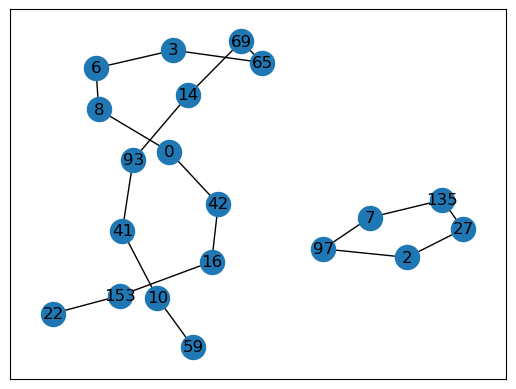

In [47]:
# Ball mapper doesn't work well regardless of epsilon
nx.draw_networkx(bm.Graph, 
                 pos = nx.spring_layout(bm.Graph, k=0.5, iterations=50, seed=23))
nx.number_connected_components(bm.Graph)

In [48]:
test_subset = X[bm.new_soft_cluster[0]]

In [49]:
test_center = X[0]

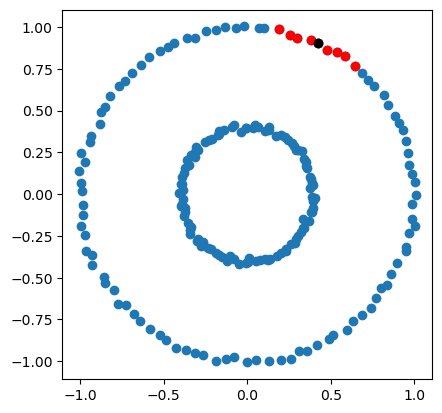

In [50]:
plt.scatter(X[:,0], X[:,1], label = "original")
plt.scatter(test_subset[:,0], test_subset[:,1], label = "original", color = "red")
# plt.scatter(test_subset2[:,0], test_subset2[:,1], label = "original", color = "green")
plt.scatter(test_center[0], test_center[1], label = "original", color = "black")
# plt.scatter(X[173,0], X[173,1], label = "original", color = "red")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

Now, fix adaptiveballmapper so that it runs through the process more than once

# Function to plot Mapper given cover

In [51]:
def plot_mapper(soft_clustering):

    landmarks = list(soft_clustering.keys())
    
    # for some reason last landmark is int64 type
    landmarks = [int(i) for i in landmarks]
    
    # find edges
    edges = [] # list of edges [[idx_v, idx_u], ...]
    for i, idx_v in enumerate(landmarks[:-1]):
        for idx_u in landmarks[i+1:]:
            if len(set(soft_clustering[idx_v]).intersection(soft_clustering[idx_u])) != 0:
                edges.append([idx_v, idx_u])


    # create Ball Mapper graph
    Graph = nx.Graph()
    Graph.add_nodes_from(landmarks)
    Graph.add_edges_from(edges)


#     for node in Graph.nodes:
#         Graph.nodes[node]['landmark'] = node
#         Graph.nodes[node]['points covered'] = soft_clustering[node]
#         Graph.nodes[node]['size'] = len(Graph.nodes[node]['points covered'])
#         Graph.nodes[node]['color'] = 'r' # TODO change the defaul color
    
    return Graph

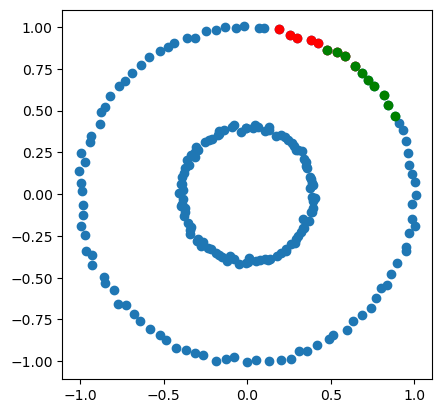

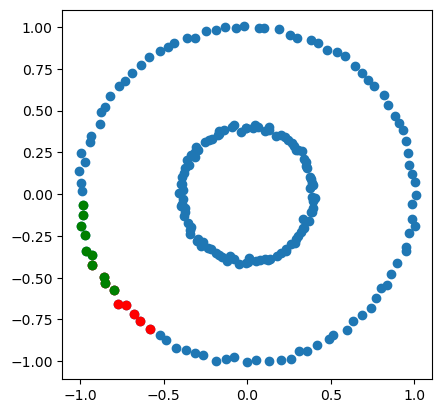

In [52]:
new_dict1 = merge_balls(X, bm.new_soft_cluster, 2)

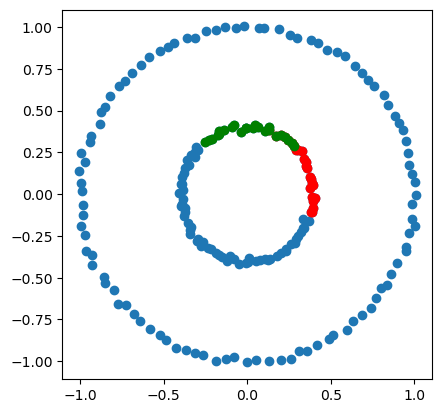

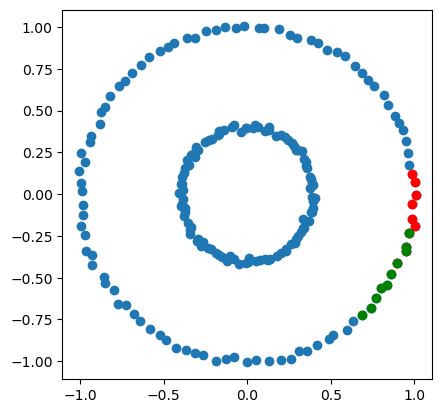

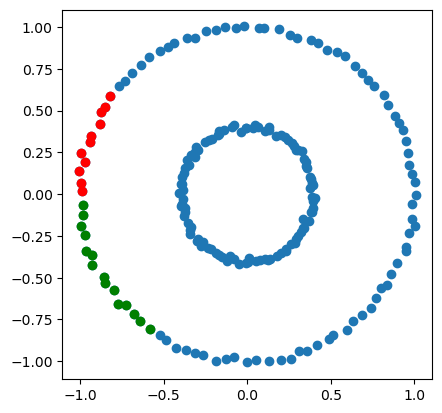

In [53]:
new_dict2 = merge_balls(X, new_dict1, 2)

In [ ]:
new_dict3 = merge_balls(X, new_dict2, 2)

In [ ]:
new_dict4 = merge_balls(X, new_dict3, 2)

In [43]:
test_graph = plot_mapper(new_dict2)

2

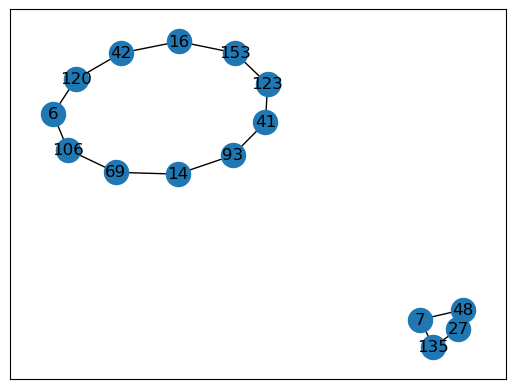

In [54]:
nx.draw_networkx(test_graph, 
                 pos=nx.spring_layout(test_graph, seed=1))
nx.number_connected_components(test_graph)

# Timing

In [ ]:
merge_balls(points, soft_clustering, n, distance=None)

In [ ]:
hard_clustering(points, subset, soft_clustering, distance=None)

In [112]:
soft_cluster_run = get_epsilon_net(X, range(len(X)), 0.31)

In [66]:
from line_profiler import LineProfiler
import random

In [113]:
lp = LineProfiler()
lp_wrapper = lp(hard_clustering)
lp_wrapper(X, range(len(X)), soft_cluster_run)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.00662997 s
File: /tmp/ipykernel_89724/3019197997.py
Function: hard_clustering at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def hard_clustering(points, subset, soft_clustering, distance=None):
     2                                               
     3                                               # if distance is not specified, use Euclidean distance
     4         1       3798.0   3798.0      0.1      if not distance:
     5         1       2834.0   2834.0      0.0          distance = lambda x, y : np.linalg.norm(x - y)
     6                                                   
     7         1       9888.0   9888.0      0.1      landmarks = list(soft_clustering.keys())
     8                                                   
     9                                               # invert soft_clustering so that it's {point:[landmarks covering point]}    
    10         1   